\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

## (a) {-}

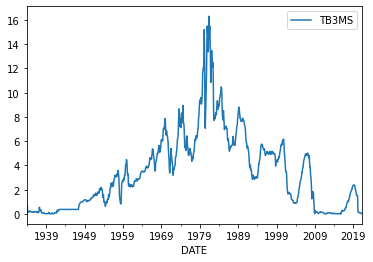

In [47]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1934, 1, 1)
end = datetime.datetime(2021, 3, 1)

tb3ms = web.DataReader('TB3MS', 'fred', start, end)
tb3ms.plot()
pass

## (b) {-}

In [2]:
import numpy as np
import statsmodels.tsa.api as smt

smt.stattools.adfuller(np.diff(tb3ms.values.ravel(), n=0))

(-1.99768609451749,
 0.2875885868267768,
 21,
 1025,
 {'1%': -3.43674585579594,
  '5%': -2.8643638720413227,
  '10%': -2.5682735516954196},
 532.4445434006693)

In [40]:
smt.stattools.adfuller(np.diff(tb3ms.values.ravel(), n=1))

(-7.807198416577612,
 7.228526169719172e-12,
 20,
 1025,
 {'1%': -3.43674585579594,
  '5%': -2.8643638720413227,
  '10%': -2.5682735516954196},
 535.0645589781107)

## (c) {-}

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import numpy as np
import statsmodels.tsa.api as smt

y = np.diff(tb3ms.values.ravel(), n=1)
res = smt.stattools.arma_order_select_ic(y, ic=['aic', 'bic'], trend='nc')
print('AIC min order: ', res.aic_min_order)
print('BIC min order: ', res.bic_min_order)

AIC min order:  (4, 2)
BIC min order:  (3, 2)


## (d) {-}

In [49]:
from statsmodels.tsa.arima_model import ARMA
from pandas import Series
import matplotlib.pyplot as plt

def tsplot(ts, title):
    fig = plt.figure(figsize=(10, 5))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    pacf_ax = plt.subplot2grid(layout, (1,1))
    acf_ax = plt.subplot2grid(layout, (1,0))

    Series(ts).plot(ax=ts_ax)
    smt.graphics.plot_acf(ts, ax=acf_ax)
    smt.graphics.plot_pacf(ts, ax=pacf_ax)
    ts_ax.set(title=title)

    plt.tight_layout()
    plt.show()

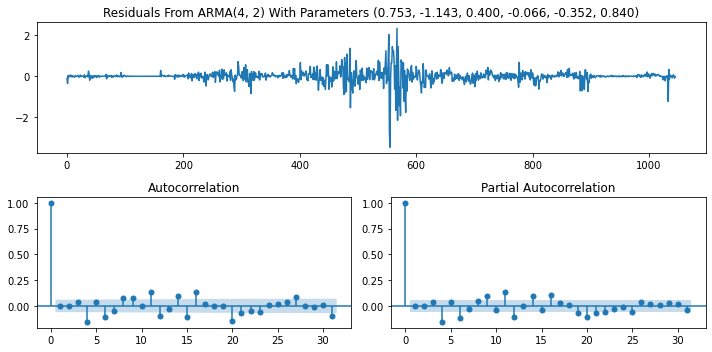

In [50]:
model42 = ARMA(y, (4, 2)).fit(trend='nc', disp=0)
tsplot(ts=model42.resid, title="Residuals From ARMA(4, 2) With Parameters (%s, %s, %s, %s, %s, %s)"%tuple('%.3f'%param for param in model42.params))

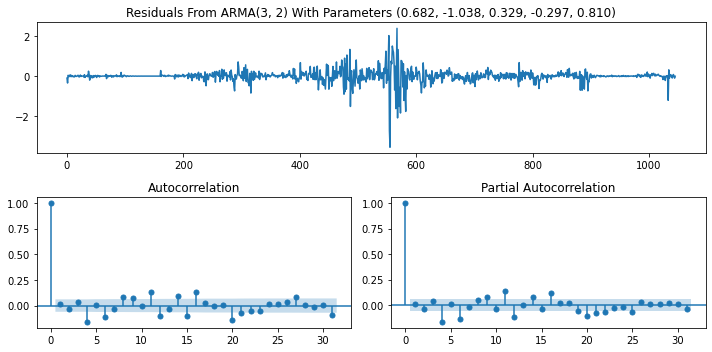

In [51]:
model32 = ARMA(y, (3, 2)).fit(trend='nc', disp=0)
tsplot(ts=model32.resid, title="Residuals From ARMA(3, 2) With Parameters (%s, %s, %s, %s, %s)"%tuple('%.3f'%param for param in model32.params))

In [42]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f'%x)
pd.merge(acorr_ljungbox(model42.resid, lags=10, return_df=True), acorr_ljungbox(model42.resid, lags=10, return_df=True), 
         left_index=True, right_index=True, suffixes=('_ARMA(4, 2)', '_ARMA(3, 2)'))

,"lb_stat_ARMA(4, 2)","lb_pvalue_ARMA(4, 2)","lb_stat_ARMA(3, 2)","lb_pvalue_ARMA(3, 2)"
1,0.00175712,0.96656408,0.00175712,0.96656408
2,0.00396460,0.99801966,0.00396460,0.99801966
3,1.41975431,0.70091082,1.41975431,0.70091082
4,26.71571571,0.00002269,26.71571571,0.00002269
5,27.88686461,0.00003830,27.88686461,0.00003830
6,40.83172156,0.00000031,40.83172156,0.00000031
7,43.16696096,0.00000031,43.16696096,0.00000031
8,49.30143285,0.00000006,49.30143285,0.00000006
9,55.71756196,0.00000001,55.71756196,0.00000001
10,55.71901170,0.00000002,55.71901170,0.00000002


In [19]:
tb3ms.head(5)

,TB3MS
DATE,
1934-01-01,0.72000000
1934-02-01,0.62000000
1934-03-01,0.24000000
1934-04-01,0.15000000
1934-05-01,0.16000000


# 2. {-}

## (a)(c) {-}

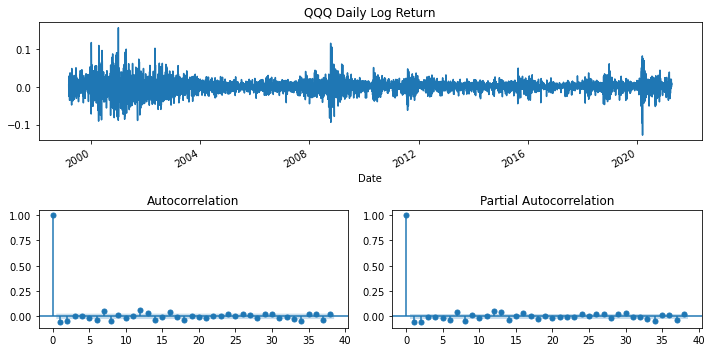

In [52]:
import pandas_datareader as pdr
import numpy as np

start = '1990-01-01'
end = '2021-04-09'
adjclose = pdr.get_data_yahoo('QQQ', start, end)['Adj Close']
logret = np.log(adjclose/adjclose.shift(1)).dropna()

tsplot(logret, 'QQQ Daily Log Return')

## (b) {-}

In [18]:
import numpy as np
import statsmodels.tsa.api as smt

smt.stattools.adfuller(np.diff(logret.values.ravel(), n=0))

(-12.731858497381559,
 9.338280133804948e-24,
 33,
 5523,
 {'1%': -3.431534563080626,
  '5%': -2.8620634597003414,
  '10%': -2.5670486363571245},
 -29093.4962398692)

## (d) {-}

In [27]:
res = smt.stattools.arma_order_select_ic(logret, ic=['aic', 'bic'], trend='nc')
print('AIC min order: ', res.aic_min_order)
print('BIC min order: ', res.bic_min_order)

AIC min order:  (4, 2)
BIC min order:  (0, 2)


## (e) {-}

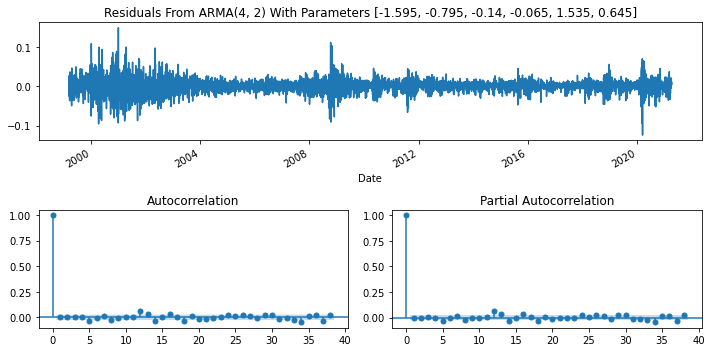

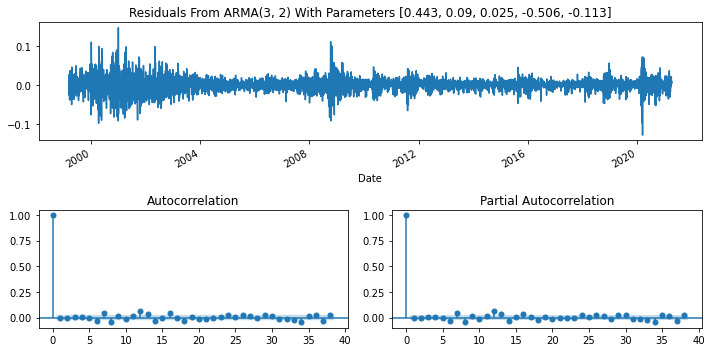

In [54]:
from IPython.display import Markdown, display

for p, q in [(4, 2), (3, 2)]:
    model = ARMA(logret, (p, q)).fit(trend='nc', disp=0)
    tsplot(ts=model.resid, title=f"Residuals From ARMA{(p, q)} With Parameters {[round(param, 3) for param in model.params.values]}")
    print()